In [ ]:
# =========================
# 1) Kurulum, Ortam ve Seed
# =========================
import os, gc, math, pickle, random, sys, time, pathlib, json, itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelBinarizer

print('Python:', sys.version)
print('TensorFlow:', tf.__version__)
print('GPU:', 'Var ✅' if tf.config.list_physical_devices('GPU') else 'Yok ⚠️')

# Reprodüksiyon
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# Kaggle'da dataset yolu
INPUT_DIR = '/kaggle/input/traffic-signs-preprocessed'
assert os.path.exists(INPUT_DIR), f"Dataset path bulunamadı: {INPUT_DIR}"

# Kullanılacak pickle
PICKLE_NAME = 'data8.pickle'  # (Gray + Local Hist Eq + Norm) - istersen 'data3.pickle' da deneyebilirsin
PICKLE_PATH = os.path.join(INPUT_DIR, PICKLE_NAME)
print('Kullanılan pickle:', PICKLE_PATH)


Anahtarlar: ['y_validation', 'x_train', 'y_train', 'x_validation', 'labels', 'x_test', 'y_test']
Şekiller: (86989, 32, 32, 1) (4410, 32, 32, 1) (12630, 32, 32, 1)
Sınıf sayısı: 43  | Görüntü şekli: (32, 32, 1)


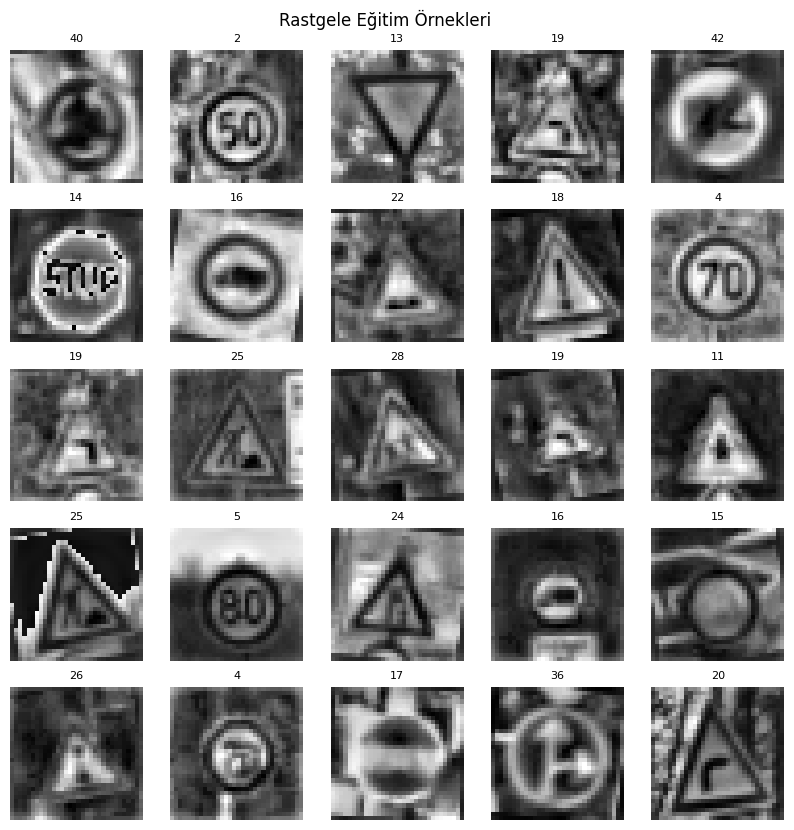

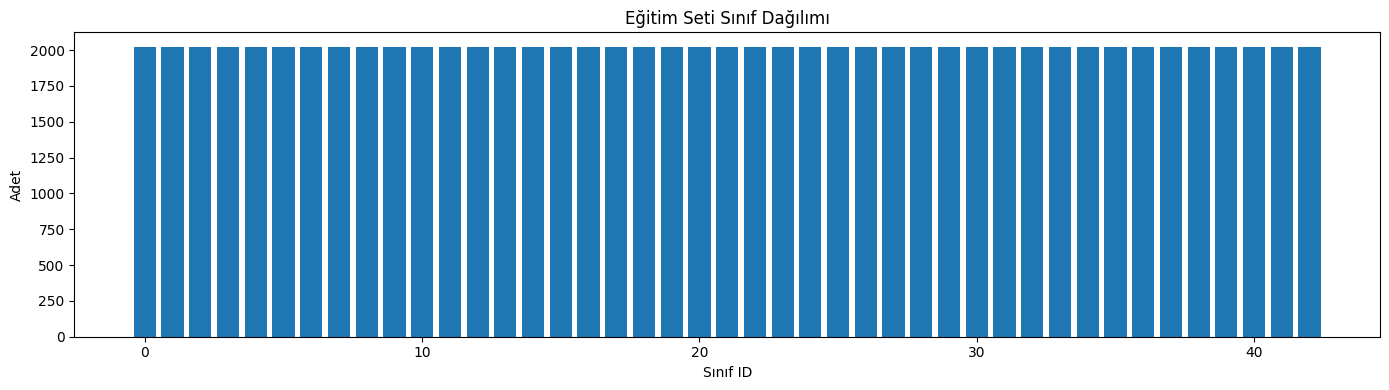

In [12]:
# ==================================
# 2) Veri Yükleme ve Temel Keşif (EDA)
# ==================================
with open(PICKLE_PATH, 'rb') as f:
    data = pickle.load(f, encoding='latin1')

print('Anahtarlar:', list(data.keys()))
x_train = data['x_train']; y_train = data['y_train']
x_val   = data['x_validation']; y_val = data['y_validation']
x_test  = data['x_test']; y_test = data['x_test']

# Channel-first -> channel-last
def to_channel_last(x):
    # (N, C, H, W) -> (N, H, W, C)
    return np.transpose(x, (0, 2, 3, 1))

x_train = to_channel_last(data['x_train']).astype('float32')
x_val   = to_channel_last(data['x_validation']).astype('float32')
x_test  = to_channel_last(data['x_test']).astype('float32')
y_train = data['y_train']; y_val = data['y_validation']; y_test = data['y_test']

NUM_CLASSES = len(np.unique(y_train))
IMG_SHAPE = x_train.shape[1:]  # (H,W,C)

print('Şekiller:', x_train.shape, x_val.shape, x_test.shape)
print('Sınıf sayısı:', NUM_CLASSES, ' | Görüntü şekli:', IMG_SHAPE)

# GTSRB sınıf isimleri
CLASS_NAMES = [
    "Speed limit (20km/h)","Speed limit (30km/h)","Speed limit (50km/h)","Speed limit (60km/h)",
    "Speed limit (70km/h)","Speed limit (80km/h)","End of speed limit (80km/h)","Speed limit (100km/h)",
    "Speed limit (120km/h)","No passing","No passing for >3.5t","Right-of-way at next intersection",
    "Priority road","Yield","Stop","No vehicles",">3.5t prohibited","No entry","General caution",
    "Dangerous curve left","Dangerous curve right","Double curve","Bumpy road","Slippery road",
    "Road narrows right","Road work","Traffic signals","Pedestrians","Children crossing","Bicycles crossing",
    "Beware of ice/snow","Wild animals crossing","End of all limits","Turn right ahead","Turn left ahead",
    "Ahead only","Go straight or right","Go straight or left","Keep right","Keep left","Roundabout mandatory",
    "End of no passing","End of no passing >3.5t"
]

# Örnek görseller
def plot_samples(images, labels, n=25):
    idx = np.random.choice(len(images), n, replace=False)
    plt.figure(figsize=(10,10))
    for i, j in enumerate(idx):
        plt.subplot(5,5,i+1)
        img = images[j].squeeze()
        if img.ndim == 2:
            plt.imshow(img, cmap='gray')
        else:
            plt.imshow(img)
        plt.axis('off')
        plt.title(int(labels[j]), fontsize=8)
    plt.suptitle('Rastgele Eğitim Örnekleri', y=0.92)
    plt.show()

plot_samples(x_train, y_train, n=25)

# Sınıf dağılımı
train_counts = pd.Series(y_train).value_counts().sort_index()
plt.figure(figsize=(14,4))
plt.bar(range(NUM_CLASSES), train_counts.values)
plt.title('Eğitim Seti Sınıf Dağılımı')
plt.xlabel('Sınıf ID'); plt.ylabel('Adet')
plt.tight_layout(); plt.show()


In [13]:
# ======================================================
# 3) One-Hot Dönüşüm ve tf.data Pipeline (Augmentation)
# ======================================================
lb = LabelBinarizer()
y_train_oh = lb.fit_transform(y_train)
y_val_oh   = lb.transform(y_val)
y_test_oh  = lb.transform(y_test)
print('One-hot şekilleri:', y_train_oh.shape, y_val_oh.shape, y_test_oh.shape)

# Not: Trafik işaretlerinde yatay flip bazı sınıflarda (sağ/sol yön) semantiği bozabilir.
# Bu yüzden flip'i kapatıp, rotation/zoom/contrast ile çeşitlilik sağlıyoruz.
data_augmentation = keras.Sequential([
    # layers.RandomFlip('horizontal'),  # İstersen sınıf-temelli koşullu yapabilirsin
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
], name='augmentation')

BATCH_SIZE_DEFAULT = 128
AUTO = tf.data.AUTOTUNE

def make_ds(X, y=None, training=False, batch_size=BATCH_SIZE_DEFAULT):
    if y is None:
        ds = tf.data.Dataset.from_tensor_slices(X)
    else:
        ds = tf.data.Dataset.from_tensor_slices((X, y))
    if training and y is not None:
        ds = ds.shuffle(4096, seed=SEED, reshuffle_each_iteration=True)
        ds = ds.map(lambda x, yy: (data_augmentation(x, training=True), yy), num_parallel_calls=AUTO)
    ds = ds.batch(batch_size).prefetch(AUTO)
    return ds

train_ds = make_ds(x_train, y_train_oh, training=True)
val_ds   = make_ds(x_val,   y_val_oh,   training=False)
test_ds  = make_ds(x_test,  y_test_oh,  training=False)


One-hot şekilleri: (86989, 43) (4410, 43) (12630, 43)


In [14]:
# =========================================
# 4) CNN Modeli (Grad-CAM uyumlu son Conv2D)
# =========================================
def build_cnn_model(img_shape=IMG_SHAPE, num_classes=NUM_CLASSES, 
                    base_filters=32, dropout_rate=0.4, l2_reg=1e-4, kernel_size=3, dense_units=256):
    reg = keras.regularizers.l2(l2_reg)
    inputs = layers.Input(shape=img_shape)
    x = inputs

    # Blok 1
    x = layers.Conv2D(base_filters, kernel_size, padding='same', kernel_regularizer=reg)(x)
    x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)
    x = layers.Conv2D(base_filters, kernel_size, padding='same', kernel_regularizer=reg)(x)
    x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D()(x); x = layers.Dropout(dropout_rate)(x)

    # Blok 2
    x = layers.Conv2D(base_filters*2, kernel_size, padding='same', kernel_regularizer=reg)(x)
    x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)
    x = layers.Conv2D(base_filters*2, kernel_size, padding='same', kernel_regularizer=reg)(x)
    x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D()(x); x = layers.Dropout(dropout_rate)(x)

    # Blok 3 (son konv 'last_conv')
    x = layers.Conv2D(base_filters*4, kernel_size, padding='same', kernel_regularizer=reg, name='last_conv')(x)
    x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)
    x = layers.GlobalAveragePooling2D()(x); x = layers.Dropout(dropout_rate)(x)

    x = layers.Dense(dense_units, activation='relu', kernel_regularizer=reg)(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs, outputs, name='cnn_gtsrb')
    return model

model = build_cnn_model()
model.summary()


Model: "cnn_gtsrb"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ last_conv (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             

 Total params: 184,203 (719.54 KB)

 Trainable params: 183,563 (717.04 KB)

 Non-trainable params: 640 (2.50 KB)

In [15]:
# =====================================================================
# 5) Callback’ler: CKPT, ES, RLR ve TENSORBOARD (istenen bonus eklendi)
# =====================================================================
LR = 3e-4
EPOCHS = 30

opt = optimizers.Adam(learning_rate=LR)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

ckpt = callbacks.ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
es   = callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=6, restore_best_weights=True, verbose=1)
rlr  = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# TensorBoard
log_dir = f"logs/{time.strftime('%Y%m%d-%H%M%S')}"
tb   = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[ckpt, es, rlr, tb],
    verbose=1
)

# Eğitim sürecini kaydet
with open('history.json', 'w') as f:
    json.dump({k: list(map(float, v)) for k, v in history.history.items()}, f)
print("Eğitim geçmişi: history.json, TensorBoard logları:", log_dir)


Epoch 1/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.0513 - loss: 3.7135
Epoch 1: val_accuracy improved from -inf to 0.03129, saving model to best_model.keras
680/680 ━━━━━━━━━━━━━━━━━━━━ 53s 60ms/step - accuracy: 0.0513 - loss: 3.7133 - val_accuracy: 0.0313 - val_loss: 4.1074 - learning_rate: 3.0000e-04
Epoch 2/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.1870 - loss: 2.8783
Epoch 2: val_accuracy improved from 0.03129 to 0.06735, saving model to best_model.keras
680/680 ━━━━━━━━━━━━━━━━━━━━ 34s 50ms/step - accuracy: 0.1871 - loss: 2.8781 - val_accuracy: 0.0673 - val_loss: 4.0053 - learning_rate: 3.0000e-04
Epoch 3/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.2963 - loss: 2.3975
Epoch 3: val_accuracy improved from 0.06735 to 0.16440, saving model to best_model.keras
680/680 ━━━━━━━━━━━━━━━━━━━━ 35s 51ms/step - accuracy: 0.2963 - loss: 2.3974 - val_accuracy: 0.1644 - val_loss: 3.4837 - learning_rate: 3.0000e-04
Epoch 4/30
679/680 ━━━━━━━━━━━━━━━

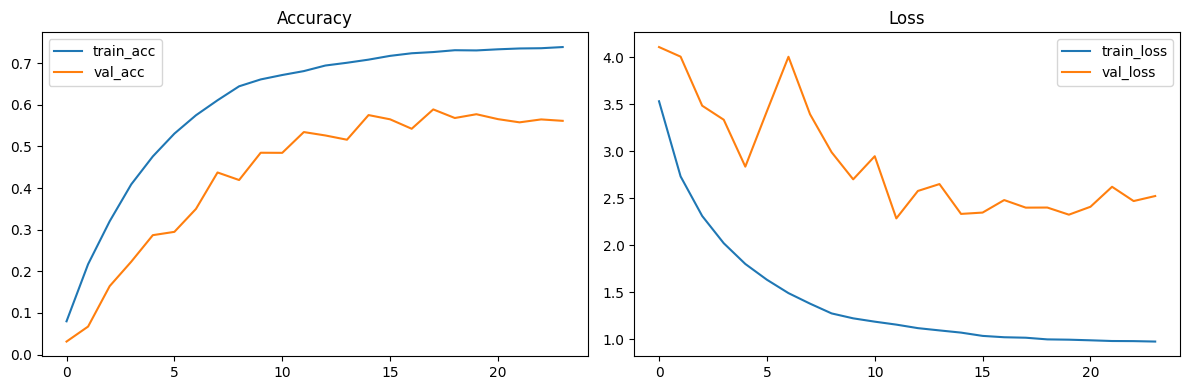

Overfit/Underfit Teşhisi: {'gap_son': 1.5481067895889282, 'yorum': 'Overfitting belirtisi: val_loss düşmüyor ve train/val gap yüksek.'}


In [16]:
# ===================================================
# 6) Grafikler ve Overfit/Underfit Teşhis Fonksiyonu
# ===================================================
def plot_training(h):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(h.history['accuracy'], label='train_acc')
    plt.plot(h.history['val_accuracy'], label='val_acc')
    plt.title('Accuracy'); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(h.history['loss'], label='train_loss')
    plt.plot(h.history['val_loss'], label='val_loss')
    plt.title('Loss'); plt.legend()
    plt.tight_layout(); plt.show()

plot_training(history)

def diagnose_overfit(h):
    tr, va = np.array(h.history['loss']), np.array(h.history['val_loss'])
    gap = va - tr
    note = "Denge fena değil."
    if (gap[-5:].mean() > 0.2) and (va[-1] >= va.min() - 1e-3):
        note = "Overfitting belirtisi: val_loss düşmüyor ve train/val gap yüksek."
    elif (tr[-5:].mean() > va[-5:].mean()) and (tr[-1] > 1.0 and va[-1] > 1.0):
        note = "Underfitting ihtimali: her iki loss da yüksek; model kapasitesini/artırmayı deneyebilirsin."
    return {"gap_son": float(gap[-1]), "yorum": note}

print("Overfit/Underfit Teşhisi:", diagnose_overfit(history))


Test Accuracy: 0.5380 | Test Loss: 2.3912


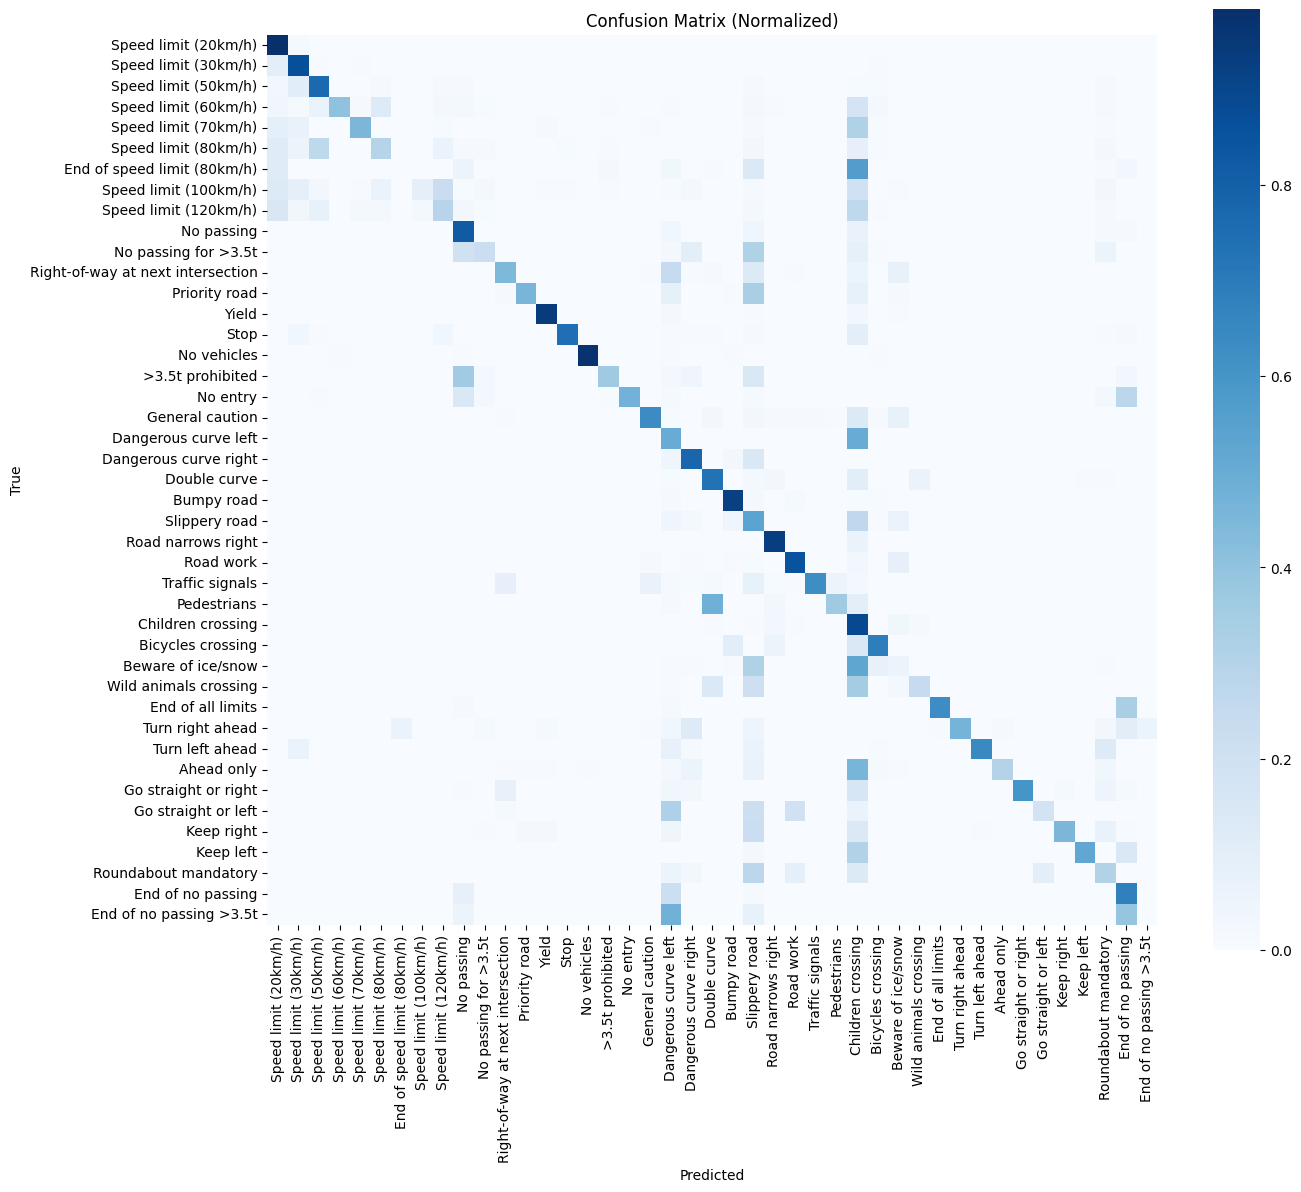

Classification Report:
                                       precision    recall  f1-score   support

              0: Speed limit (20km/h)     0.1302    0.9833    0.2300        60
              1: Speed limit (30km/h)     0.7153    0.8653    0.7832       720
              2: Speed limit (50km/h)     0.6878    0.7667    0.7251       750
              3: Speed limit (60km/h)     0.9733    0.4044    0.5714       450
              4: Speed limit (70km/h)     0.9255    0.4515    0.6069       660
              5: Speed limit (80km/h)     0.6254    0.2968    0.4026       630
       6: End of speed limit (80km/h)     0.0000    0.0000    0.0000       150
             7: Speed limit (100km/h)     0.7636    0.0933    0.1663       450
             8: Speed limit (120km/h)     0.4196    0.2956    0.3468       450
                        9: No passing     0.5543    0.8187    0.6611       480
             10: No passing for >3.5t     0.7449    0.2212    0.3411       660
11: Right-of-way at next int

In [17]:
# ==============================================================================
# 7) Test Değerlendirme + Normalize CM (etiket isimleri) + Classification Report
# ==============================================================================
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f'Test Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}')

# Tahminler
y_prob = model.predict(test_ds, verbose=0)
y_pred = np.argmax(y_prob, axis=1)
y_true = np.argmax(np.vstack([y for _, y in test_ds.unbatch().as_numpy_iterator()]), axis=1)

# Confusion Matrix (normalize)
cm = confusion_matrix(y_true, y_pred)
cm_norm = cm / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(14,12))
sns.heatmap(cm_norm, cmap='Blues', cbar=True,
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, square=True)
plt.xticks(rotation=90); plt.yticks(rotation=0)
plt.title('Confusion Matrix (Normalized)')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.tight_layout(); plt.show()

print('Classification Report:')
print(classification_report(y_true, y_pred, digits=4, target_names=[f"{i}: {n}" for i,n in enumerate(CLASS_NAMES)]))


Grad-CAM için son konv katmanı: last_conv


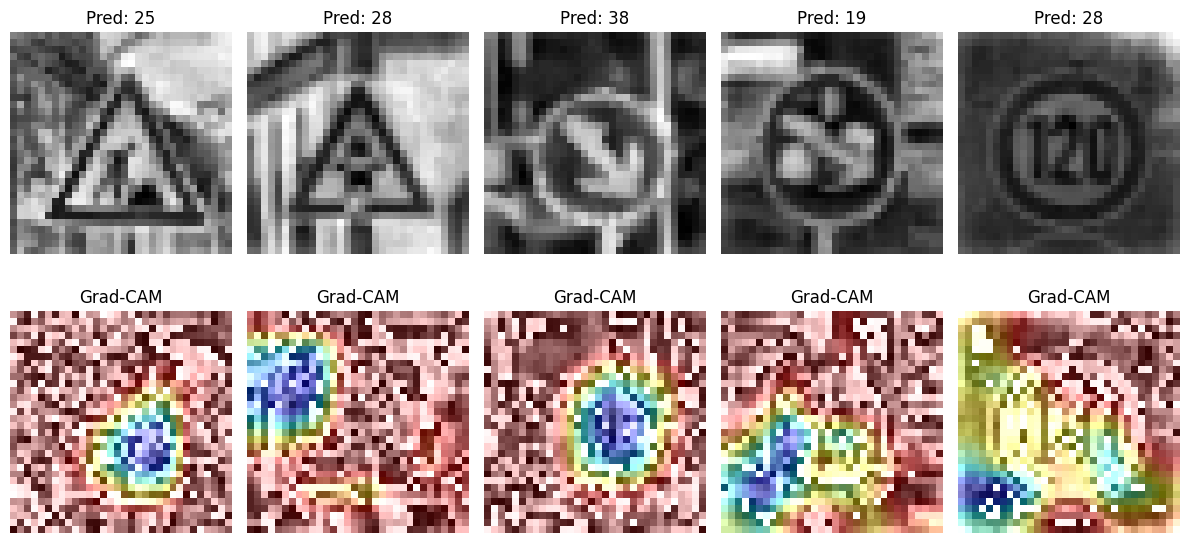

In [19]:
# =========================
# 8) GRAD-CAM (Sağlam Sürüm)
# =========================
import cv2

def get_last_conv_layer_name(m):
    for layer in reversed(m.layers):
        if isinstance(layer, layers.Conv2D):
            return layer.name
    raise ValueError('Modelde Conv2D katmanı bulunamadı.')

LAST_CONV = get_last_conv_layer_name(model)
print('Grad-CAM için son konv katmanı:', LAST_CONV)

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None, target_size=None):
    grad_model = keras.models.Model([model.inputs],
                                    [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, conv_out)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_out = conv_out[0]
    heatmap = tf.tensordot(conv_out, pooled_grads, axes=(2, 0))
    heatmap = tf.maximum(heatmap, 0)
    maxv = tf.reduce_max(heatmap)
    heatmap = heatmap / (maxv + 1e-8)

    if target_size is not None:
        H, W = target_size
        heatmap = tf.image.resize(heatmap[..., tf.newaxis], (H, W), method='bilinear')
        heatmap = tf.squeeze(heatmap, axis=-1)
    return heatmap.numpy()

def show_gradcam_on_image(img, heatmap, alpha=0.4):
    if img.ndim == 2 or (img.ndim == 3 and img.shape[-1] == 1):
        base = np.repeat(np.squeeze(img)[..., None], 3, axis=-1)
    else:
        base = img.copy()
    base_u8 = (base * 255.0).astype('uint8') if base.dtype != np.uint8 else base
    heatmap_u8 = np.uint8(np.clip(heatmap, 0, 1) * 255)
    heatmap_color = cv2.applyColorMap(heatmap_u8, cv2.COLORMAP_JET)
    over = cv2.addWeighted(base_u8, 1.0, heatmap_color, alpha, 0)
    return over

# Örnek gösterim
num_show = 5
sample = x_test[:num_show]
preds = model.predict(sample, verbose=0)
pred_labels = np.argmax(preds, axis=1)

plt.figure(figsize=(12, 6))
for i in range(num_show):
    img = sample[i:i+1]
    H, W = sample[i].shape[:2]
    heatmap = make_gradcam_heatmap(img, model, LAST_CONV, target_size=(H, W))
    cam = show_gradcam_on_image(sample[i], heatmap)

    plt.subplot(2, num_show, i + 1)
    disp = sample[i].squeeze()
    plt.imshow(disp if disp.ndim==2 else disp)
    if disp.ndim==2: plt.imshow(disp, cmap='gray')
    plt.axis('off'); plt.title(f"Pred: {pred_labels[i]}")

    plt.subplot(2, num_show, num_show + i + 1)
    plt.imshow(cam); plt.axis('off'); plt.title('Grad-CAM')

plt.tight_layout(); plt.show()


In [22]:
# ==========================================
# 9) Transfer Learning: MobileNetV2 (Uyarısız)
# ==========================================
def to_rgb_224(x):
    x = tf.convert_to_tensor(x)
    if x.shape[-1] == 1:
        x = tf.image.grayscale_to_rgb(x)
    x = tf.image.resize(x, (224, 224), method='bilinear')
    x = keras.applications.mobilenet_v2.preprocess_input(x * 255.0)  # [-1, 1]
    return x

def make_ds_224(X, y_oh, batch=64, training=False, seed=42):
    ds = tf.data.Dataset.from_tensor_slices((X, y_oh))
    if training:
        ds = ds.shuffle(4096, seed=seed, reshuffle_each_iteration=True)
    ds = ds.map(lambda xx, yy: (to_rgb_224(xx), yy), num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch).prefetch(tf.data.AUTOTUNE)
    return ds

def build_tl_model(num_classes=NUM_CLASSES):
    inputs = keras.Input(shape=(224, 224, 3))
    # ÇÖZÜM: input_shape ver, base'i functional olarak 'inputs' üzerine çağır
    base = keras.applications.MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3)
    )
    base.trainable = False
    x = base(inputs, training=False)            # base'i 'inputs' ile çağırıyoruz
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer=keras.optimizers.Adam(1e-3),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

train224 = make_ds_224(x_train, y_train_oh, training=True)
val224   = make_ds_224(x_val,   y_val_oh,   training=False)
test224  = make_ds_224(x_test,  y_test_oh,  training=False)

tl_model = build_tl_model()
hist_tl = tl_model.fit(
    train224,
    validation_data=val224,
    epochs=8,
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)],
    verbose=1
)
print("TL Test:")
tl_model.evaluate(test224, verbose=1)


Epoch 1/8
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 95s 63ms/step - accuracy: 0.4872 - loss: 1.8707 - val_accuracy: 0.6880 - val_loss: 1.0300
Epoch 2/8
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 78s 57ms/step - accuracy: 0.7470 - loss: 0.8749 - val_accuracy: 0.7088 - val_loss: 0.9542
Epoch 3/8
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 77s 56ms/step - accuracy: 0.7809 - loss: 0.7434 - val_accuracy: 0.7200 - val_loss: 0.9373
Epoch 4/8
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 77s 57ms/step - accuracy: 0.7944 - loss: 0.6908 - val_accuracy: 0.7342 - val_loss: 0.9028
Epoch 5/8
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 76s 56ms/step - accuracy: 0.8024 - loss: 0.6608 - val_accuracy: 0.7347 - val_loss: 0.9103
Epoch 6/8
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 77s 56ms/step - accuracy: 0.8095 - loss: 0.6321 - val_accuracy: 0.7327 - val_loss: 0.9349
Epoch 7/8
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 77s 56ms/step - accuracy: 0.8142 - loss: 0.6120 - val_accuracy: 0.7320 - val_loss: 0.9356
Epoch 8/8
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 76s 56ms/step - accuracy: 0.8129 - loss: 0

[0.9781327843666077, 0.7265241742134094]

In [23]:
# ===================================================
# 10) Hızlı & Kapsamlı Hiperparametre Araması (HPO)
# ===================================================

# Zaman sınırlayıcı
class TimeLimit(callbacks.Callback):
    def __init__(self, seconds=300, verbose=1, check_every_n_batches=10):
        super().__init__()
        self.seconds = seconds
        self.verbose = verbose
        self.check_every_n_batches = check_every_n_batches
        self._start = None
    def on_train_begin(self, logs=None):
        self._start = time.time()
    def on_train_batch_end(self, batch, logs=None):
        if batch % self.check_every_n_batches != 0:
            return
        if time.time() - self._start > self.seconds:
            if self.verbose:
                print(f"\n[TimeLimit] {self.seconds}s sınırı aşıldı; eğitimi durduruyorum.")
            self.model.stop_training = True

AUTO = tf.data.AUTOTUNE

def _cardinality(ds, fallback_batches):
    try:
        c = tf.data.experimental.cardinality(ds).numpy()
        if c > 0:
            return int(c)
    except Exception:
        pass
    return int(fallback_batches)

fallback_train_batches = int(np.ceil(len(x_train)/BATCH_SIZE_DEFAULT))
fallback_val_batches   = int(np.ceil(len(x_val)/BATCH_SIZE_DEFAULT))
train_batches_full = _cardinality(train_ds, fallback_train_batches)
val_batches_full   = _cardinality(val_ds,   fallback_val_batches)

HP_TRAIN_STEPS = min(100, train_batches_full)   # alt-küme
HP_VAL_STEPS   = min(40,  val_batches_full)

print(f"HP araması {HP_TRAIN_STEPS} train batch / {HP_VAL_STEPS} val batch ile yapılacak.")

# Arama uzayı (genişletildi)
search_space = {
    'base_filters': [32, 48],
    'dropout_rate': [0.3, 0.5],
    'lr': [1e-3, 3e-4],
    'kernel_size': [3, 5],
    'dense_units': [128, 256],
    'batch_size': [64, 128],
    'optimizer': ['adam', 'sgd']
}
MAX_EPOCHS       = 8
TIME_LIMIT_SEC   = 300
MIN_DELTA_ACC    = 1e-3

def pick_opt(name, lr):
    if name == 'adam':
        return optimizers.Adam(lr)
    elif name == 'sgd':
        return optimizers.SGD(lr, momentum=0.9)
    else:
        raise ValueError(name)

results = []
trial_idx = 0

for bf in search_space['base_filters']:
  for dr in search_space['dropout_rate']:
    for lr in search_space['lr']:
      for ks in search_space['kernel_size']:
        for du in search_space['dense_units']:
          for bs in search_space['batch_size']:
            for optn in search_space['optimizer']:
              trial_idx += 1
              print(f"\n>>> Trial {trial_idx}: filters={bf}, drop={dr}, lr={lr}, k={ks}, dense={du}, bs={bs}, opt={optn}")
              tf.keras.backend.clear_session(); gc.collect()
              m = build_cnn_model(base_filters=bf, dropout_rate=dr, kernel_size=ks, dense_units=du)
              m.compile(optimizer=pick_opt(optn, lr), loss='categorical_crossentropy', metrics=['accuracy'])

              train_hp = make_ds(x_train, y_train_oh, training=True,  batch_size=bs).take(HP_TRAIN_STEPS).cache().prefetch(AUTO)
              val_hp   = make_ds(x_val,   y_val_oh,   training=False, batch_size=bs).take(HP_VAL_STEPS).cache().prefetch(AUTO)
              opt_ds = tf.data.Options(); opt_ds.experimental_deterministic = False
              train_hp = train_hp.with_options(opt_ds); val_hp = val_hp.with_options(opt_ds)

              cbs = [
                  callbacks.EarlyStopping(monitor='val_accuracy', patience=2,
                                          restore_best_weights=True, min_delta=MIN_DELTA_ACC, verbose=1),
                  callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-6, verbose=1),
                  callbacks.TerminateOnNaN(),
                  TimeLimit(seconds=TIME_LIMIT_SEC, verbose=1),
              ]
              try:
                  h = m.fit(train_hp, validation_data=val_hp, epochs=MAX_EPOCHS, verbose=0, callbacks=cbs)
                  val_acc = float(max(h.history.get('val_accuracy', [0.0])))
              except Exception as e:
                  print(f"Trial failed: {e}")
                  val_acc = 0.0

              results.append({'base_filters':bf,'dropout_rate':dr,'lr':lr,'kernel_size':ks,
                              'dense_units':du,'batch_size':bs,'optimizer':optn,'val_acc':val_acc})
              del m; gc.collect()

hp_df = pd.DataFrame(results).sort_values('val_acc', ascending=False).reset_index(drop=True)
display(hp_df.head(15))
hp_df.to_csv('hp_results_extended.csv', index=False)
print("Kaydedildi: hp_results_extended.csv")


HP araması 100 train batch / 35 val batch ile yapılacak.

>>> Trial 1: filters=32, drop=0.3, lr=0.001, k=3, dense=128, bs=64, opt=adam

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 4.

>>> Trial 2: filters=32, drop=0.3, lr=0.001, k=3, dense=128, bs=64, opt=sgd

Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 1.

>>> Trial 3: filters=32, drop=0.3, lr=0.001, k=3, dense=128, bs=128, opt=adam

Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 3.

>>> Trial 4: filters=32, drop=0.3, lr=0.001, k=3, dense=128, bs=128, opt=s

,base_filters,dropout_rate,lr,kernel_size,dense_units,batch_size,optimizer,val_acc
0,32,0.3,0.0010,5,256,128,adam,0.575737
1,48,0.3,0.0003,5,256,128,adam,0.563492
2,48,0.3,0.0010,5,128,128,adam,0.516553
3,48,0.3,0.0010,5,256,128,adam,0.502041
4,32,0.3,0.0010,5,128,128,adam,0.425170
5,48,0.3,0.0003,5,256,64,adam,0.408929
6,32,0.3,0.0010,5,128,64,adam,0.382143
7,48,0.5,0.0010,5,128,128,adam,0.378005
8,48,0.3,0.0010,5,256,64,adam,0.355804
9,48,0.3,0.0010,3,128,128,adam,0.333560


Kaydedildi: hp_results_extended.csv
